# Set up environment

In [1]:
# Import the 'drive' module from the 'google.colab' package to enable Google Drive integration.
# Then, mount Google Drive to the '/drive' directory within the Colab environment.
# The 'force_remount=True' parameter ensures that the Drive is remounted even if it was previously mounted.

from google.colab import drive
drive.mount('/drive', force_remount=True)

# This allows easy access to files stored in Google Drive.
%cd '/drive/MyDrive/Colab Notebooks/Projects/House Price Competition'

Mounted at /drive
/drive/MyDrive/Colab Notebooks/Projects/House Price Competition


In [2]:
import pandas as pd
# look into it later
pd.plotting.register_matplotlib_converters()
import numpy as np
import matplotlib.pyplot as plt
# look into it later
%matplotlib inline
import seaborn as sns
import numpy as np


# bmh makes more visual appealing
plt.style.use('bmh')

# set seed for reproducibility
np.random.seed(0)

# Load Data

In [3]:
# the test.csv file has no actual sales price for the competition purpose. So we need to split the trainning dataset into training and validation datasets
from sklearn.model_selection import train_test_split

# load the data
# df = pd.read_csv('../input/train.csv')
X = pd.read_csv('train.csv', index_col='Id')
X_test = pd.read_csv('test.csv', index_col='Id')

X.head(10)
# X_train.tail(2)
# X_test.head(2)
# set id column as index
# df = df.set_index('Id')

# X.info()
# X_test.info()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900


# Preliminary Investigation

In [4]:
# shape of training data (num_rows, num_columns)
print(X.shape)

# columns with missing values
missing_value_cols = X.isnull().sum()
# print('Columns with missing values:')
# print(missing_value_cols[missing_value_cols > 0])

# numerical columns with missing value
num_cols_with_missing = [col for col in X.columns if X[col].dtype != 'object' and X[col].isnull().sum() > 0]
print('Numerical columns with missing value:')
print(X[num_cols_with_missing].isnull().sum())

# categorical columns with missing value
cat_cols_with_missing = [col for col in X.columns if X[col].dtype == 'object' and X[col].isnull().sum()]
print('Categorical columns with missing value:')
print(X[cat_cols_with_missing].isnull().sum())

total_cells = np.product(X.shape)
total_missing_cells = missing_value_cols.sum()

percentage_missing_values = total_missing_cells/total_cells * 100
print('Percentage of missing values: ' + str(format(percentage_missing_values, '.2f')) + '%')

(1460, 80)
Numerical columns with missing value:
LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64
Categorical columns with missing value:
Alley           1369
MasVnrType       872
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64
Percentage of missing values: 6.70%


Due to small percentage of missing value, the best approach to handle missing value would be dropping columns with missing value.
***However, as later steps show that imputation can produce better results.***

# Handle Missing Value

**Important question:** are these values missing because they weren't recorded or because they don't exist?
- if they don't exist, keep them as NaN
- if they weren't recorded, try to guess what they might have been (imputation), or remove them

It's good to have a look at each column in the dataset documentation to find the answers.

## Handle Missing Value in Numerical Columns

### Select Numerical Columns

In [5]:
# remove rows with missing target – SalePrice
X.dropna(axis=0, subset=['SalePrice'], inplace=True)

# separate target from predictors
y = X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)

# we'll use only numerical predictors
num_X = X.select_dtypes(exclude=['object'])
# num_X = X[[col for col in X.columns if X[col].dtype != 'object']]
# num_X_test = X_test.select_dtypes(exclude=['object'])



### Examine Distribution of Numerical Columns with Missing Value

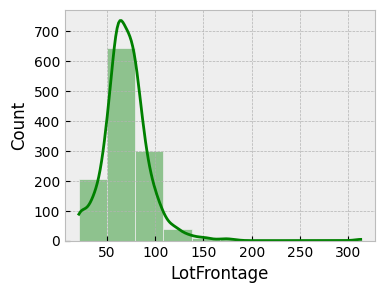

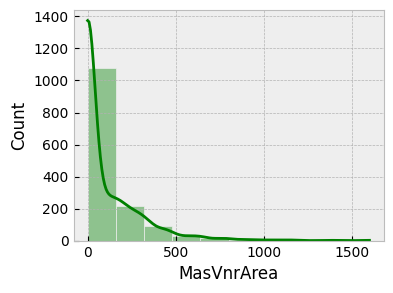

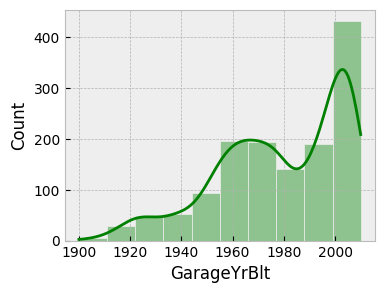

In [6]:
for col in num_cols_with_missing:
  # Set the width and height of the figure
  plt.figure(figsize=(4,3))
  sns.histplot(num_X[col], color='g', bins=10, alpha=0.4, kde=True) # need to review wide-form and long-form for hue parameter
  # sns.boxplot(data=col, y='SalePrice', x='Street')

### Choose a Model and Define Function to Measure Quality of the Model

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

### Option 1. Drop Columns with Missing Value Approach (Inter ML Course)

In [8]:
# drop columns
reduced_X = num_X.drop(num_cols_with_missing, axis=1)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(reduced_X, y, train_size=0.8, test_size=0.2, random_state=0)

print("MAE from Approach 1 (Drop columns with missing values):")
print(score_dataset(X_train, X_valid, y_train, y_valid))

MAE from Approach 1 (Drop columns with missing values):
18866.728767123288


### Option 2. Imputation Approach

In [9]:
from sklearn.impute import SimpleImputer

imputed_X = num_X.copy()

# Imputation using mean yields better result than using median even when all 3 columns are skewed, probably because the tree-based models can handle skewness well
imputer = SimpleImputer(strategy='mean')  # For numerical data
imputed_X[num_cols_with_missing] = imputer.fit_transform(imputed_X[num_cols_with_missing])

# Imputation removed column names; put them back
imputed_X.columns = num_X.columns

# another way to immpute
# imputed_X.fillna(imputed_X.mean(), inplace=True)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(imputed_X, y, train_size=0.8, test_size=0.2, random_state=0)

print("MAE from Approach 2 (Imputation):")
print(score_dataset(X_train, X_valid, y_train, y_valid))

MAE from Approach 2 (Imputation):
18344.41210045662


### Option 3. Extention of Imputation Approach


In [10]:
# Make copy to avoid changing original data (when imputing)
ext_imputed_X = num_X.copy()

# Make new columns indicating what will be imputed
for col in num_cols_with_missing:
    ext_imputed_X[col + '_was_missing'] = ext_imputed_X[col].isnull()

col_names = ext_imputed_X.columns

# Imputation
imputer = SimpleImputer()
ext_imputed_X = pd.DataFrame(imputer.fit_transform(ext_imputed_X))
# ext_imputed_X = imputer.fit_transform(ext_imputed_X)

# Imputation removed column names; put them back
ext_imputed_X.columns = col_names

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(ext_imputed_X, y, train_size=0.8, test_size=0.2, random_state=0)

print("MAE from Approach 3 (An Extension to Imputation):")
print(score_dataset(X_train, X_valid, y_train, y_valid))

MAE from Approach 3 (An Extension to Imputation):
18622.706506849314


**Conclusion:** Option 2 produced the best result.

In [ ]:
from sklearn.impute import SimpleImputer

col_names = X.columns

# Imputation using mean yields better result than using median even when all 3 columns are skewed, probably because the tree-based models can handle skewness well
imputer = SimpleImputer(strategy='mean')  # For numerical data
X[num_cols_with_missing] = imputer.fit_transform(X[num_cols_with_missing])

# Imputation removed column names; put them back
X.columns = col_names

print(X[num_cols_with_missing].isnull().sum())
# another way to immpute
# imputed_X.fillna(imputed_X.mean(), inplace=True)

LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64


**Important:** If we run the following code, it will generate errors because the missing values in categorical columns haven't been handled yet and the model only works with numerical value

In [ ]:
# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

print("MAE from Approach 2 (Imputation):")
print(score_dataset(X_train, X_valid, y_train, y_valid))

## Handle Missing Value in Categorical Columns

### Select Categorical Columns

In [ ]:
# we'll use only categorical predictors
cat_X = X.select_dtypes(include=['object'])
# cat_X = X[[col for col in X.columns if X[col].dtype == 'object']]

# Exploratory Data Analysis (EDA)

## Examine Sales Prices

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
['Pave' 'Grvl']


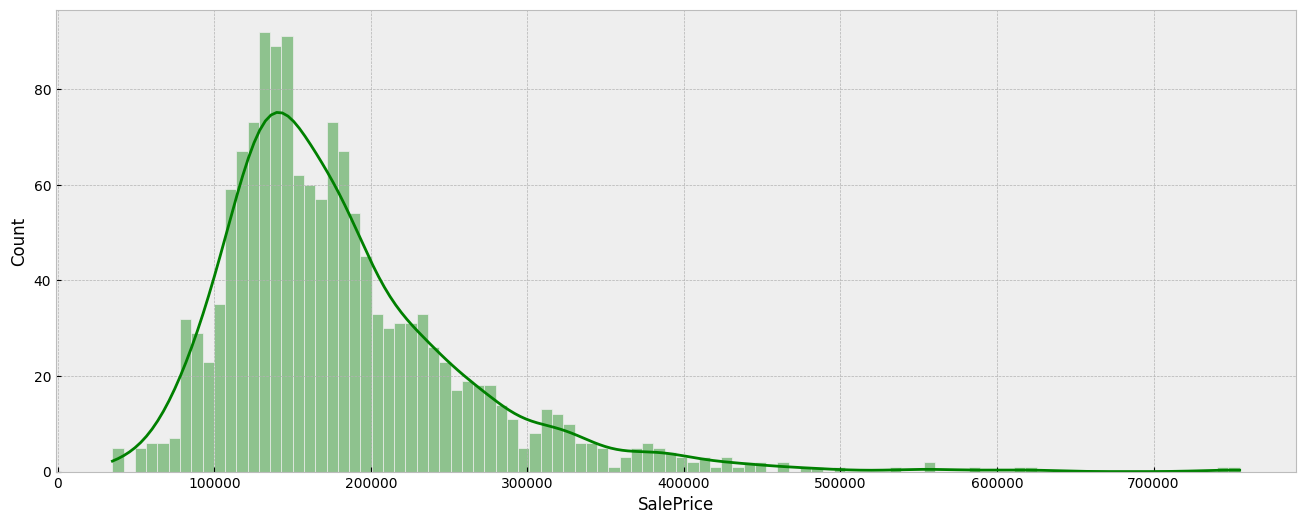

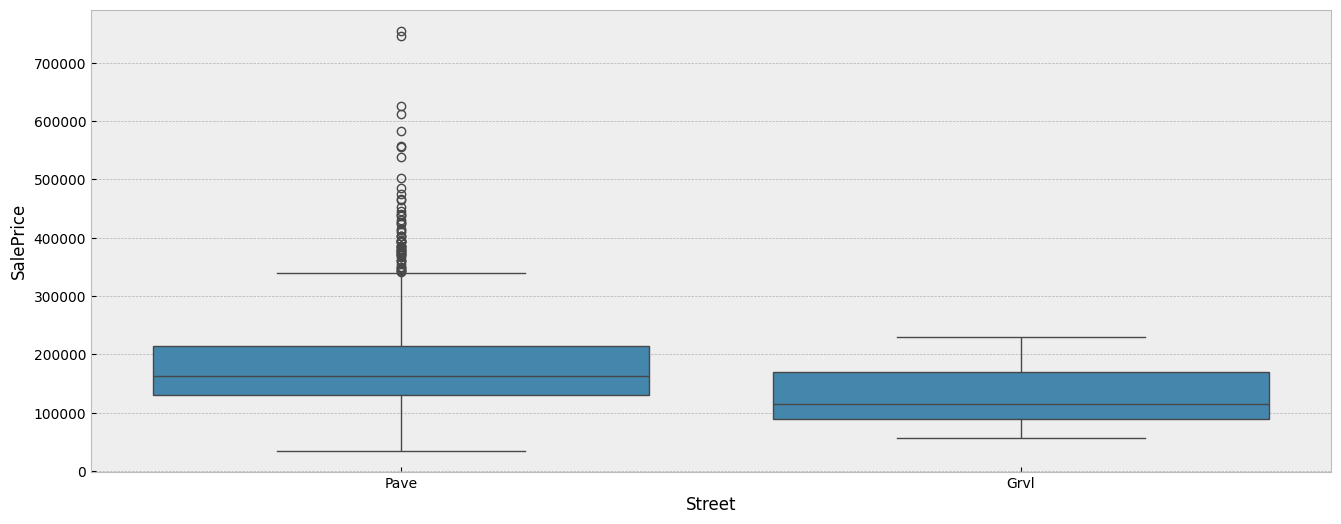

In [ ]:
print(df1['SalePrice'].describe())
print(df1.Street.unique())

# Set the width and height of the figure
plt.figure(figsize=(16,6))
sns.histplot(df1['SalePrice'], color='g', bins=100, alpha=0.4, kde=True) # need to review wide-form and long-form for hue parameter

# # Line chart showing Sale Price
# sns.lineplot(data=df1['SalePrice'], label='Sales Price')

# # Add title
# plt.title('House data')

# sns.barplot(x=df1.index, y=df1['SalePrice'])

plt.figure(figsize=(16,6))
sns.boxplot(data=df1, y='SalePrice', x='Street')


**Normalization:** SalePrice is skewed right with outliers, so we can normalize it by log transformation

count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: log_SalePrice, dtype: float64


<Axes: xlabel='log_SalePrice', ylabel='Count'>

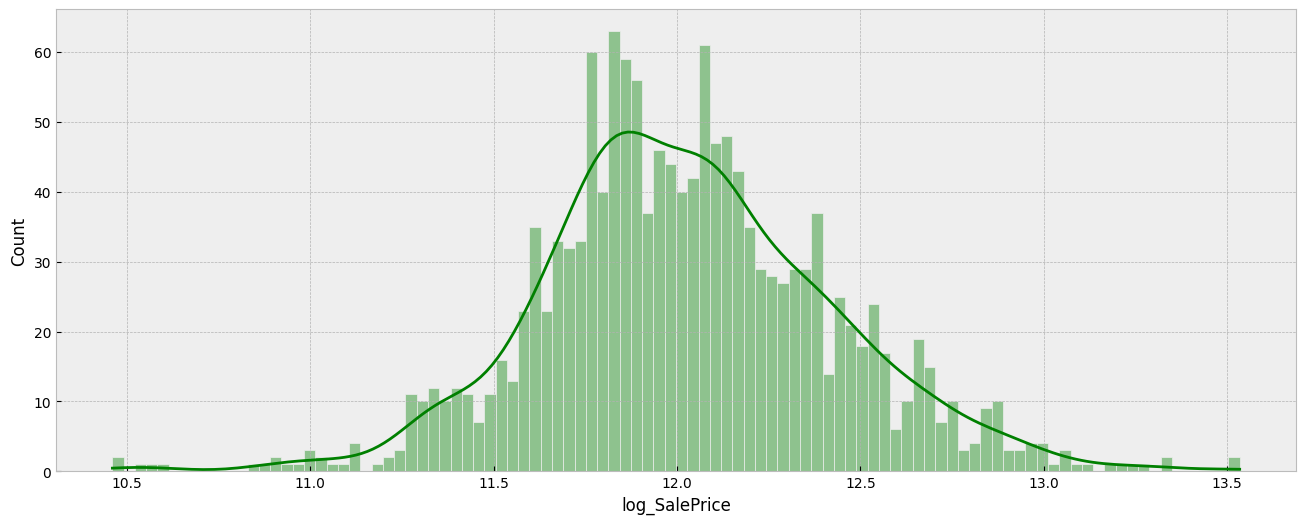

In [ ]:
df1['log_SalePrice'] = np.log(df1['SalePrice'])
print(df1['log_SalePrice'].describe())
plt.figure(figsize=(16,6))
sns.histplot(df1['log_SalePrice'], color='g', bins=100, alpha=0.4, kde=True)

## Finding numerical features and their correlation with target feature

In [ ]:
# print(df1.dtypes)
numerical_cols = [col for col in df1.columns if df1[col].dtypes != 'object']
numerical_df = df1[numerical_cols]
numerical_df.head()
correlation_matrix = numerical_df.corr() # computes the pairwise correlation of all numeric columns in the DataFrame
# print(correlation_matrix['SalePrice'].sort_values(ascending=False)) # correlation values between SalePrice and every other numerical feature in the dataset

In [ ]:
# Create scatter plots with best-fit lines
for feature in numerical_cols:
    plt.figure(figsize=(4, 3))
    sns.regplot(x=feature, y='SalePrice', data=df1, scatter_kws={'alpha':0.5})
    plt.title(f'SalePrice vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.show()
    print(correlation_matrix['SalePrice'][feature])

NameError: name 'numerical_cols' is not defined

Text(0.5, 1.0, 'Heatmap of Feature Correlations')

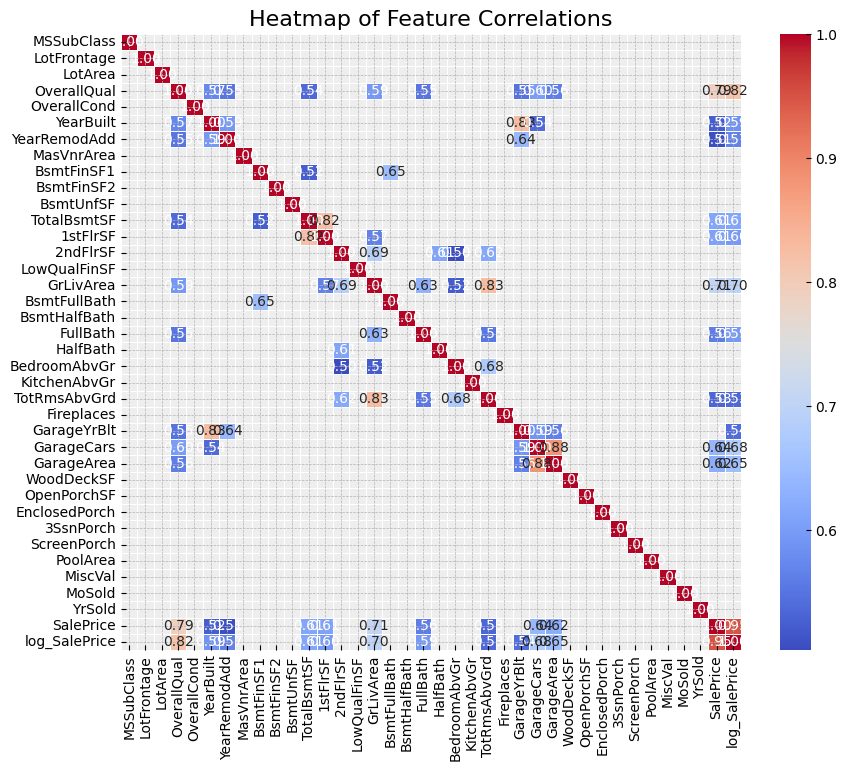

In [ ]:
filtered_correlation = correlation_matrix[(correlation_matrix > 0.5) | (correlation_matrix < -0.5)]

# Replace weaker correlations with NaN to leave them blank in the heatmap
filtered_correlation = filtered_correlation.replace(0, np.nan)

# visualize correlation between features
# Set the size of the heatmap
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(filtered_correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add title and labels (optional)
plt.title('Heatmap of Feature Correlations', fontsize=16)




# Data Pre-processing



1. Handle Missing Data (Intermediate ML course)

2. Build a baseline model

3. Feature Engineering

For a feature to be useful, it must have a relationship to the target that your model is able to learn. Linear models, for instance, are only able to learn linear relationships. So, when using a linear model, your goal is to transform the features to make their relationship to the target linear.

**Example:** you were trying to predict the Price of square plots of land from the Length of one side. Fitting a linear model directly to Length gives poor results: the relationship is not linear.

If we square the Length feature to get 'Area', however, we create a linear relationship.

2.1. Determine the most important features with mutual information

3.2. Invent new features

3.3. Encode high-cardinality categoricals with a target encoding

3.4. Create segmentation features with k-means clustering

3.5. Decompose a dataset's variation into features with principal component analysis

4. Categorical Features Encoding (Intermediate ML course)

  Most machine learning models will generate errors with they are fed with these features (Intermediate ML course)

In [ ]:
categorical_cols = [col for col in df1.columns if df1[col].dtype =='object']
categorical_df = df1[categorical_cols]
categorical_df.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
4,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
5,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


4.1. Choosing encoding methods (drop the features, ordinal encoding for ordinal variables, or one-hot encoding for norminal variables)
One-hot encoding should not be applied to features that have more than 15 different values (cardinality > 15).

In [ ]:
for col in categorical_df.columns:
  print(col, len(categorical_df[col].unique()))

MSZoning 5
Street 2
LotShape 4
LandContour 4
Utilities 2
LotConfig 5
LandSlope 3
Neighborhood 25
Condition1 9
Condition2 8
BldgType 5
HouseStyle 8
RoofStyle 6
RoofMatl 8
Exterior1st 15
Exterior2nd 16
ExterQual 4
ExterCond 5
Foundation 6
BsmtQual 5
BsmtCond 5
BsmtExposure 5
BsmtFinType1 7
BsmtFinType2 7
Heating 6
HeatingQC 5
CentralAir 2
Electrical 6
KitchenQual 4
Functional 7
GarageType 7
GarageFinish 4
GarageQual 6
GarageCond 6
PavedDrive 3
SaleType 9
SaleCondition 6


4. Outlier Treatment